# Goal
I will randomly permute a brain image and try to recover it.

The result will need to be a matrix, but the columns of the matrix should transform like a vector.

i.e. which way is x? which way is y? which way is z?

# caveats
I have a feeling the network will not be able to learn left right flips with any degree of accuracy.

If we try to predict the matrix I think we'll end up just predicting 0.

For that reason I think we will need a random output.  If it can't get it right it will guess.

Not sure exactly how this would work.

It seems it was able to predict left right reasonably.  I'm still not sure if this is the best approach or not.

# v01
In version 1 I will apply rotations

In v01 copy 1, I will use a regular net

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import torch
import moment_kernels_3d as mk
from glob import glob
import nibabel as nib
from os.path import basename,split,join

# start with a dataset


In [2]:
dtype = torch.float32

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self,pattern=None):
        self.pattern = pattern
        if pattern is None:
            self.pattern = '/home/dtward/data/mricloud_atlases/Adult27-55/*MNI.img'
        
        self.files = glob(self.pattern)
    def __len__(self):
        return len(self.files)
    def __getitem__(self,i):
        I = nib.load(self.files[i]).get_fdata().squeeze() # remove time
        return torch.tensor(I[None],dtype=dtype) # add batch

In [4]:
# maybe go for adni
class Dataset(torch.utils.data.Dataset):
    def __init__(self,pattern=None,train=True):
        self.pattern = pattern
        if pattern is None:
            self.pattern = '/nafs/dtward/adni_rigid/rigid_align_v01/*.npy' # v02 doesn't seem to be pointing the right way
        
        self.files = glob(self.pattern)
        self.files = list(filter(lambda x: 'labels' not in x, self.files))
        
        self.ids = [basename(f)[:10] for f in self.files]
        self.unique_ids = list(set(self.ids))
        
        # chose a test train split based on unique ids
        self.ntest = int(len(self.unique_ids)*0.1)
        np.random.seed(0)
        self.test_unique_ids = np.random.choice(self.unique_ids,self.ntest)
        self.files_test = [f for f in self.files if basename(f)[:10] in self.test_unique_ids]
        self.files_train = [f for f in self.files if f not in self.files_test]
        self.train = train
        if self.train:
            self.files = self.files_train
        else:
            self.files = self.files_test
    def __len__(self):
        return len(self.files)
    def __getitem__(self,i):
        #I = nib.load(self.files[i]).get_fdata().squeeze() # remove time
        I = np.load(self.files[i],mmap_mode='r')#[:,20:-20,20:-20,90:-30]
        # I don't think I should subset, because I'm picking the size below when resampling
        
        
        return torch.tensor(I,dtype=dtype) # add batch

In [5]:
dataset = Dataset()
dataset_test = Dataset(train=False)

In [6]:
dataset[0].shape

torch.Size([1, 193, 239, 263])

In [7]:
len(dataset),len(dataset_test),

(3287, 390)

In [8]:
'''
s = 0.0
s2 = 0.0
count = 0
for x in dataset:
    s += torch.sum(x)
    s2 += torch.sum(x**2)
    count += x.numel()
mu = s/count
std = torch.sqrt(s2/count - mu**2)
'''

'\ns = 0.0\ns2 = 0.0\ncount = 0\nfor x in dataset:\n    s += torch.sum(x)\n    s2 += torch.sum(x**2)\n    count += x.numel()\nmu = s/count\nstd = torch.sqrt(s2/count - mu**2)\n'

In [9]:
mu,std = (torch.tensor(32.8549), torch.tensor(33.6492))

In [10]:
# (tensor(32.8549), tensor(33.6492))
mu,std

(tensor(32.8549), tensor(33.6492))

In [11]:
loader = torch.utils.data.DataLoader(dataset,shuffle=True,batch_size=8,num_workers=0)
loader_test = torch.utils.data.DataLoader(dataset_test,shuffle=False,batch_size=8,num_workers=0)

In [12]:
for x in loader:
    break

In [13]:
xI0 = [torch.arange(n) - (n-1)/2 for n in x.shape[2:]]
x0 = torch.stack([x[0] for x in xI0])
x1 = torch.stack([x[-1] for x in xI0])

In [14]:
n = torch.max(torch.tensor(x.shape))
xI = torch.arange(n) - (n-1)/2
XI = torch.stack(torch.meshgrid(xI,xI,xI,indexing='ij'),-1)

# now a network

In [15]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.c0 = 1
        self.c1 = 4
        self.co = 3
        self.k = 3
        self.p = 1
        
        self.d = mk.Downsample()
        self.scalarsigmoid = mk.ScalarSigmoid()
        self.vectorsigmoid = mk.VectorSigmoid()
        
        self.ss0 = mk.ScalarToScalar(self.c0,self.c1,self.k,self.p)
        self.sv0 = mk.ScalarToVector(self.c0,self.c1,self.k,self.p)
        self.bs0 = mk.ScalarBatchnorm(self.c1)
        self.bv0 = mk.VectorBatchnorm(self.c1)
        
        self.ss1 = mk.ScalarToScalar(self.c1,self.c1*2,self.k,self.p)
        self.sv1 = mk.ScalarToVector(self.c1,self.c1*2,self.k,self.p)
        self.vs1 = mk.VectorToScalar(self.c1,self.c1*2,self.k,self.p)
        self.vv1 = mk.VectorToVector(self.c1,self.c1*2,self.k,self.p)
        self.bs1 = mk.ScalarBatchnorm(self.c1*2)
        self.bv1 = mk.VectorBatchnorm(self.c1*2)
        
        
        self.ss2 = mk.ScalarToScalar(self.c1*2,self.c1*4,self.k,self.p)
        self.sv2 = mk.ScalarToVector(self.c1*2,self.c1*4,self.k,self.p)
        self.vs2 = mk.VectorToScalar(self.c1*2,self.c1*4,self.k,self.p)
        self.vv2 = mk.VectorToVector(self.c1*2,self.c1*4,self.k,self.p)
        self.bs2 = mk.ScalarBatchnorm(self.c1*4)
        self.bv2 = mk.VectorBatchnorm(self.c1*4)
        
        
        self.ss3 = mk.ScalarToScalar(self.c1*4,self.c1*8,self.k,self.p)
        self.sv3 = mk.ScalarToVector(self.c1*4,self.c1*8,self.k,self.p)
        self.vs3 = mk.VectorToScalar(self.c1*4,self.c1*8,self.k,self.p)
        self.vv3 = mk.VectorToVector(self.c1*4,self.c1*8,self.k,self.p)
        self.bs3 = mk.ScalarBatchnorm(self.c1*8)
        self.bv3 = mk.VectorBatchnorm(self.c1*8)
        
        
        self.ss4 = mk.ScalarToScalar(self.c1*8,self.c1*16,self.k,self.p)
        self.sv4 = mk.ScalarToVector(self.c1*8,self.c1*16,self.k,self.p)
        self.vs4 = mk.VectorToScalar(self.c1*8,self.c1*16,self.k,self.p)
        self.vv4 = mk.VectorToVector(self.c1*8,self.c1*16,self.k,self.p)
        self.bs4 = mk.ScalarBatchnorm(self.c1*16)
        self.bv4 = mk.VectorBatchnorm(self.c1*16)
        
        self.ss5 = mk.ScalarToScalar(self.c1*16,self.c1*32,self.k,self.p)
        self.sv5 = mk.ScalarToVector(self.c1*16,self.c1*32,self.k,self.p)
        self.vs5 = mk.VectorToScalar(self.c1*16,self.c1*32,self.k,self.p)
        self.vv5 = mk.VectorToVector(self.c1*16,self.c1*32,self.k,self.p)
        self.bs5 = mk.ScalarBatchnorm(self.c1*32)
        self.bv5 = mk.VectorBatchnorm(self.c1*32)
        
        
        
        # last one
        self.sv6 = mk.ScalarToVector(self.c1*32,self.co,self.k,self.p)
        self.vv6 = mk.VectorToVector(self.c1*32,self.co,self.k,self.p)
        
    def forward(self,x):
        # map to scalar ve
        
        
        xs,xv = self.ss0(x),self.sv0(x)                
        xs,xv = self.d(xs),self.d(xv)
        xs,xv = self.bs0(xs), self.bv0(xv)
        xs,xv = self.scalarsigmoid(xs),self.vectorsigmoid(xv)
        
        
        xs,xv = self.ss1(xs) + self.vs1(xv), self.sv1(xs) + self.vv1(xv)
        xs,xv = self.d(xs),self.d(xv)
        xs,xv = self.bs1(xs), self.bv1(xv)
        xs,xv = self.scalarsigmoid(xs),self.vectorsigmoid(xv)
        
        xs,xv = self.ss2(xs) + self.vs2(xv), self.sv2(xs) + self.vv2(xv)
        xs,xv = self.d(xs),self.d(xv)
        xs,xv = self.bs2(xs), self.bv2(xv)
        xs,xv = self.scalarsigmoid(xs),self.vectorsigmoid(xv)
        
        xs,xv = self.ss3(xs) + self.vs3(xv), self.sv3(xs) + self.vv3(xv)
        xs,xv = self.d(xs),self.d(xv)
        xs,xv = self.bs3(xs), self.bv3(xv)
        xs,xv = self.scalarsigmoid(xs),self.vectorsigmoid(xv)
        
        xs,xv = self.ss4(xs) + self.vs4(xv), self.sv4(xs) + self.vv4(xv)
        xs,xv = self.d(xs),self.d(xv)
        xs,xv = self.bs4(xs), self.bv4(xv)
        xs,xv = self.scalarsigmoid(xs),self.vectorsigmoid(xv)
        #print(xs.shape)
        xs,xv = self.ss5(xs) + self.vs5(xv), self.sv5(xs) + self.vv5(xv)
        xs,xv = self.d(xs),self.d(xv)
        xs,xv = self.bs5(xs), self.bv5(xv)
        xs,xv = self.scalarsigmoid(xs),self.vectorsigmoid(xv)
        #print(xs.shape) # this is 1,2,1, now I can't conv with a size 1
        
        xv = self.sv6(xs) + self.vv6(xv)
        xv = torch.mean(xv,(-1,-2,-3))
        
        
        return xv

In [16]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.ch0 = 1
        self.ch1 = 4*3
        #self.ch1 = 4*4 
        self.ch1 = 3 # with this I get about the same number of parameters
        # for a "fair" comparison I could multiply by 4 (1 scalar + 3 vector)
        # but this is a huge number of parameters
        self.cho = 3*3
        self.k = 3
        self.p = 1
        self.s = 2
        
        self.c0 = torch.nn.Conv3d(self.ch0,self.ch1,self.k,self.s,self.p)
        self.b0 = torch.nn.BatchNorm3d(self.ch1)
        self.c1 = torch.nn.Conv3d(self.ch1,2*self.ch1,self.k,self.s,self.p)
        self.b1 = torch.nn.BatchNorm3d(2*self.ch1)
        self.c2 = torch.nn.Conv3d(2*self.ch1,4*self.ch1,self.k,self.s,self.p)
        self.b2 = torch.nn.BatchNorm3d(4*self.ch1)
        self.c3 = torch.nn.Conv3d(4*self.ch1,8*self.ch1,self.k,self.s,self.p)
        self.b3 = torch.nn.BatchNorm3d(8*self.ch1)
        self.c4 = torch.nn.Conv3d(8*self.ch1,16*self.ch1,self.k,self.s,self.p)
        self.b4 = torch.nn.BatchNorm3d(16*self.ch1)
        self.c5 = torch.nn.Conv3d(16*self.ch1,32*self.ch1,self.k,self.s,self.p)
        self.b5 = torch.nn.BatchNorm3d(32*self.ch1)
        
        
        

        
        # last one
        self.c6 = torch.nn.Conv3d(self.ch1*32,self.cho,self.k,1,self.p)
        
        
    def forward(self,x):
        x = torch.relu(self.b0(self.c0(x)))
        x = torch.relu(self.b1(self.c1(x)))
        x = torch.relu(self.b2(self.c2(x)))
        x = torch.relu(self.b3(self.c3(x)))
        x = torch.relu(self.b4(self.c4(x)))
        x = torch.relu(self.b5(self.c5(x)))
        x = self.c6(x)         # convention is last time we don't normalize or put through nonlinearity
        
        x = torch.mean(x,(-1,-2,-3))
        
        
        return x

In [17]:
net = Net()
net = net.to(dtype)

In [18]:
count = 0
for p in net.parameters():
    count += p.numel()
count
# 190880 parameters

189711

In [19]:
import time

In [20]:
#start = time.time()
#y = net(x)
#print(time.time()-start)

In [21]:
#x.shape

In [22]:
# 3.5 seconds (for mricloud)
# 7.5 seconds (adni)
# could

In [23]:
((10000/200)**3*3.5)/60/60/24 # would take a bout 5 days for a neural network of about the complexity will we need
# we will want to do this at whole brain scale, local disease burden
# same system can study aging

5.063657407407407

In [24]:
# field array programable something
# 

In [25]:
#y.shape

In [26]:
#test = net(x) + net(x.flip(-1,-2,-3)) # a flip should change the sign, so a sum should be 0
#test

In [27]:
#test = net(x) + net(x.flip(-1,-2,-3)).flip(-1,-2,-3)
#fig,ax = plt.subplots()
#ax.imshow(test[0,0,test.shape[2]//2].detach())

In [28]:
# let's train the network
lr = 1e-3
optimizer = torch.optim.Adam(net.parameters(),lr)

In [29]:
from scipy.linalg import expm

In [30]:
resume = True

In [31]:
out_prefix = 'brain_orientation_v01b_'

In [32]:
def draw():
    ax['E_'].cla()
    ax['E_'].plot(Esave_,label='train')
    ax['E_'].plot(Esave_test_,label='test')
    ax['E_'].set_yscale('log')
    ax['E_'].legend()
    ax['E'].cla()
    ax['E'].plot(Esave,label='train')
    ax['E'].plot(Esavetest,label='test')
    ax['E'].set_yscale('log')
    ax['E'].legend()
    ax['truth'].cla()
    ax['truth'].imshow(R,vmin=-1,vmax=1)
    ax['pred'].cla()
    ax['pred'].imshow(ymat[0].clone().detach(),vmin=-1,vmax=1)
    ax['err'].cla()
    ax['err'].imshow((ymat[0]-R).clone().detach(),vmin=-1,vmax=1)
    
    arrowscale = 1/60
    ax['I1'].cla()
    ax['I1'].imshow(x[0,0,x.shape[2]//2])
    ax['I1'].quiver(x.shape[-1]//2,x.shape[-2]//2, ymat[0,-1,0].item(), ymat[0,-2,0].item(), angles='xy', scale_units='xy',scale=arrowscale,color='r',width=0.02)
    ax['I1'].quiver(x.shape[-1]//2,x.shape[-2]//2, ymat[0,-1,1].item(), ymat[0,-2,1].item(), angles='xy', scale_units='xy',scale=arrowscale,color='g',width=0.02)
    ax['I1'].quiver(x.shape[-1]//2,x.shape[-2]//2, ymat[0,-1,2].item(), ymat[0,-2,2].item(), angles='xy', scale_units='xy',scale=arrowscale,color='b',width=0.02)




    ax['I2'].cla()
    ax['I2'].imshow(x[0,0,:,x.shape[3]//2])
    ax['I2'].quiver(x.shape[-1]//2,x.shape[-3]//2, ymat[0,-1,0].item(), ymat[0,-3,0].item(), angles='xy', scale_units='xy',scale=arrowscale,color='r',width=0.02)
    ax['I2'].quiver(x.shape[-1]//2,x.shape[-3]//2, ymat[0,-1,1].item(), ymat[0,-3,1].item(), angles='xy', scale_units='xy',scale=arrowscale,color='g',width=0.02)
    ax['I2'].quiver(x.shape[-1]//2,x.shape[-3]//2, ymat[0,-1,2].item(), ymat[0,-3,2].item(), angles='xy', scale_units='xy',scale=arrowscale,color='b',width=0.02)



    ax['I3'].cla()
    ax['I3'].imshow(x[0,0,:,:,x.shape[4]//2])
    ax['I3'].quiver(x.shape[-2]//2,x.shape[-3]//2, ymat[0,-2,0].item(), ymat[0,-3,0].item(), angles='xy', scale_units='xy',scale=arrowscale,color='r',width=0.02)
    ax['I3'].quiver(x.shape[-2]//2,x.shape[-3]//2, ymat[0,-2,1].item(), ymat[0,-3,1].item(), angles='xy', scale_units='xy',scale=arrowscale,color='g',width=0.02)
    ax['I3'].quiver(x.shape[-2]//2,x.shape[-3]//2, ymat[0,-2,2].item(), ymat[0,-3,2].item(), angles='xy', scale_units='xy',scale=arrowscale,color='b',width=0.02)

    fig.canvas.draw()

<IPython.core.display.Javascript object>


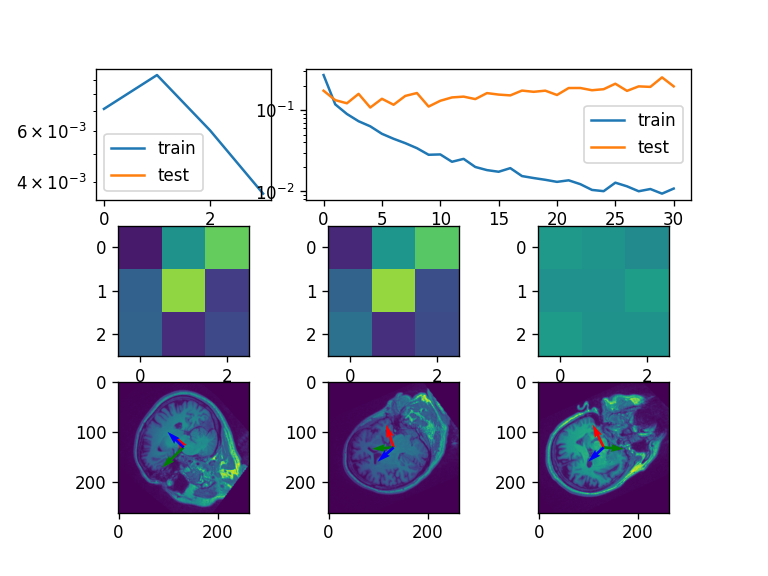

/home/dtward/.local/intelpython3/lib/python3.7/site-packages/torch/nn/functional.py:4228: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


KeyboardInterrupt: 

In [33]:
fig,ax = plt.subplot_mosaic([['E_','E','E'],['truth','pred','err'],['I1','I2','I3']])
Esave = []
Esavetest = []
nepochs = 10000
nepochs = 31
if resume:
    Esave = torch.load(out_prefix + f'energy.pt')
    Esavetest = torch.load(out_prefix + f'energytest.pt')
    finished_epochs = len(Esave)
    net.load_state_dict(torch.load(out_prefix + 'net.pt'))
    optimizer.load_state_dict(torch.load(out_prefix + 'optimizer.pt'))
    
for e in range(nepochs):
    if resume and e < finished_epochs:
        continue
    Esave_ = []
    Esave_test_ = []
    for x in loader:
        
        
        # get a rotation                
        w = np.random.rand(3)
        w = w/np.sqrt(np.sum(w**2))
        w = w *np.random.rand()*np.pi
        W = np.array([[0.0,w[0],w[1]],
                     [-w[0],0.0,w[2]],
                     [-w[1],-w[2],0.0]])
        R = expm(W)
        R = torch.tensor(R,dtype=dtype)
        
        # random flip
        if np.random.rand() > 0.5:
            R = -R # this is a reflection in 3D, although it wouldn't be in 2D
        
        
        Ri = torch.linalg.inv(R)
        
        Xs = (Ri@XI[...,None])[...,0]
        Xs = (Xs - x0)/(x1 - x0) # now it is about 0 to 1
        Xs = Xs*2-1 # now -1 to 1
        x = torch.nn.functional.grid_sample(x,Xs[None].repeat(x.shape[0],1,1,1,1).flip(-1))
        
        
        # normalize
        x = (x - mu)/std
                    
        y = net(x)
        #ymat = y.reshape(-1,3,3) # this is actually not quite right, see below with arange
        ymat = y.reshape(-1,3,3).transpose(-1,-2) 
        err = torch.mean((ymat - R)**2)
        Esave_.append(err.item())
        
        optimizer.zero_grad()
        err.backward()        
        optimizer.step()
        draw()
        #if len(Esave_) > 1: break
        
        
        
    Esave.append(np.mean(Esave_))
    
    net.eval()
    with torch.no_grad():
        
        for x in loader_test:

            # get a rotation                
            w = np.random.rand(3)
            w = w/np.sqrt(np.sum(w**2))
            w = w *np.random.rand()*np.pi
            W = np.array([[0.0,w[0],w[1]],
                         [-w[0],0.0,w[2]],
                         [-w[1],-w[2],0.0]])
            R = expm(W)
            R = torch.tensor(R,dtype=dtype)

            # random flip
            if np.random.rand() > 0.5:
                R = -R # this is a reflection in 3D, although it wouldn't be in 2D


            Ri = torch.linalg.inv(R)

            Xs = (Ri@XI[...,None])[...,0]
            Xs = (Xs - x0)/(x1 - x0) # now it is about 0 to 1
            Xs = Xs*2-1 # now -1 to 1
            x = torch.nn.functional.grid_sample(x,Xs[None].repeat(x.shape[0],1,1,1,1).flip(-1))


            # normalize
            x = (x - mu)/std

            y = net(x)
            #ymat = y.reshape(-1,3,3) # this is actually not quite right, see below with arange
            ymat = y.reshape(-1,3,3).transpose(-1,-2) 
            err = torch.mean((ymat - R)**2)
            Esave_test_.append(err.item())            
            draw()
            #if len(Esave_test_) > 1: break
    net.train()
    Esavetest.append(np.mean(Esave_test_))


    
    torch.save(net.state_dict(),out_prefix + f'net.pt')
    torch.save(optimizer.state_dict(),out_prefix + f'optimizer.pt')
    torch.save(Esave,out_prefix + f'energy.pt')
    torch.save(Esavetest,out_prefix + f'energytest.pt')
    
    fig.canvas.draw()
    

In [ ]:
fig

In [ ]:
asdf

In [ ]:
# I could quantify variability by flipping the image, then multiplying by -1, and checking the angle difference

In [ ]:
net.load_state_dict(torch.load(out_prefix + 'net.pt'))
net.eval()

In [ ]:
for p in net.parameters():
    p.requires_grad = False

In [ ]:
# to do
# test all permutations
# and test random samples

nsample = 10
for x in loader_test:
    out = []
    for s in range(nsample):
        # get a rotation                
        w = np.random.rand(3)
        w = w/np.sqrt(np.sum(w**2))
        w = w *np.random.rand()*np.pi
        W = np.array([[0.0,w[0],w[1]],
                     [-w[0],0.0,w[2]],
                     [-w[1],-w[2],0.0]])
        R = expm(W)
        R = torch.tensor(R,dtype=dtype)
        
        # random flip
        if np.random.rand() > 0.5:
            R = -R # this is a reflection in 3D, although it wouldn't be in 2D
        
        if s == 0:
            R = torch.eye(3,dtype=dtype)
        Ri = torch.linalg.inv(R)
        Xs = (Ri@XI[...,None])[...,0]
        Xs = (Xs - x0)/(x1 - x0) # now it is about 0 to 1
        Xs = Xs*2-1 # now -1 to 1
        x_ = torch.nn.functional.grid_sample(x,Xs[None].repeat(x.shape[0],1,1,1,1).flip(-1))


        # normalize
        x_ = (x_ - mu)/std
        y = net(x_)

        #ymat = y.reshape(-1,3,3) # this is actually not quite right, see below with arange
        ymat = y.reshape(-1,3,3).transpose(-1,-2) 
        # rotate the vector back, so it should match the original
        ymat_ = Ri@ymat
        #err = torch.mean((ymat - R)**2)
        out.append(ymat) 
        # ymat_[i] should always equal ymat[0]
        # i.e. if we rotate the vectors in the inverse way we rorated the image, we should get the same
        asdf
        # TODO, find RMS average error
        # in units of angle degrees (or radians or whatever units), 
        # and compare between the two networks
        # the two networks are already saved
        
        # the statment will be
        # our network gives a "rotation error of X degrees, and the standard network gives a rotation error
        # of Y degrees.  AND, X < Y, therefore good."
        # maybe there's a way to report this statistically
        # like instead of average, we say, what fraction of images does it work better on.
        
    
    

In [ ]:
x0

In [ ]:
asdf
# below is all scratch

In [ ]:
out

In [ ]:
err,err_

In [ ]:
err

In [ ]:
count = 0
for x in loader_test:
    count += x.shape[0]

In [ ]:
count

In [ ]:
# after about 100 images we seem to be getting A and S pretty well
# the first column, R, is still pretty tricky.

In [ ]:
x = x.flip((-1,-2,-3))

In [ ]:
ymat.shape

In [ ]:
# if I watch the training the first component starts off pretty close to 0, but then it does grow
# but we get to it much slower than the other components

In [ ]:
torch.arange(9).reshape(3,3)

In [ ]:
ymat[0],mat

In [ ]:
y = net(x[0,None])
y.reshape(3,3).T

In [ ]:
y = net(x[0,None].permute(0,1,2,4,3))
y.reshape(3,3).T

In [ ]:
y = net(x[0,None].permute(0,1,3,2,4))
y.reshape(3,3).T

In [ ]:
y = net(x[0,None].permute(0,1,3,4,2))
y.reshape(3,3).T

In [ ]:
y = net(x[0,None].permute(0,1,4,2,3))
y.reshape(3,3).T

In [ ]:
y = net(x[0,None].permute(0,1,4,3,2))
y.reshape(3,3).T

In [ ]:
y = net(x[0,None].flip(-1))
y.reshape(3,3).T

In [ ]:
# what if I wanted to do a gradcam?
# hook(module, grad_input, grad_output) -> tuple(Tensor) or None
globaldict = {}



def ss2hook(module, grad_input, grad_output):
     globaldict['ss2'] = grad_input                
def sv2hook(module, grad_input, grad_output):
     globaldict['sv2'] = grad_input                
def vs2hook(module, grad_input, grad_output):
     globaldict['vs2'] = grad_input                
def vv2hook(module, grad_input, grad_output):
     globaldict['vv2'] = grad_input                
    
ss2hookhandle = net.ss2.register_full_backward_hook(ss2hook)
sv2hookhandle = net.sv2.register_full_backward_hook(sv2hook)
vs2hookhandle = net.vs2.register_full_backward_hook(vs2hook)
vv2hookhandle = net.vv2.register_full_backward_hook(vv2hook)


In [ ]:
for x in loader:
    break
xind = 2
optimizer.zero_grad()
y = net(x[xind,None])
y.backward(gradient=torch.diag(torch.tensor([1.0,0.0,0.0])).ravel()[None])
# note the first axis is LR

In [ ]:
# we will take the sum over channels, but only the positive part
test = torch.sum(globaldict['ss2'][0]*(globaldict['ss2'][0] > 0),(0,1))
test = test + torch.sum(globaldict['sv2'][0]*(globaldict['sv2'][0] > 0),(0,1))
test = test + torch.sum(globaldict['vs2'][0]*(globaldict['vs2'][0] > 0),(0,1))
test = test + torch.sum(globaldict['vv2'][0]*(globaldict['vv2'][0] > 0),(0,1))

In [ ]:
from scipy.ndimage import gaussian_filter
test = torch.tensor(gaussian_filter(test,1))

In [ ]:
q = torch.quantile(test.ravel(),0.95)
fig,ax = plt.subplots(1,3,figsize=(8,3))
fig.subplots_adjust(left=0,right=1,wspace=0,bottom=0,top=1)
ax[0].imshow(x[xind,0,x.shape[2]//2],extent=(0,1,0,1),cmap='gray')
toshow = test[test.shape[0]//2].clone()
toshow = toshow/q
ax[0].imshow(torch.ones_like(toshow),alpha=toshow.clip(0,1),extent=(0,1,0,1),cmap='autumn')
ax[0].axis('off')

ax[1].imshow(x[xind,0,:,x.shape[3]//2],extent=(0,1,0,1),cmap='gray')
toshow = test[:,test.shape[1]//2].clone()
toshow = toshow/q
ax[1].imshow(torch.ones_like(toshow),alpha=toshow.clip(0,1),extent=(0,1,0,1),cmap='autumn')
ax[1].axis('off')

ax[2].imshow(x[xind,0,:,:,x.shape[4]//2],extent=(0,1,0,1),cmap='gray',)
toshow = test[:,:,test.shape[2]//2].clone()
toshow = toshow/q
ax[2].imshow(torch.ones_like(toshow),alpha=toshow.clip(0,1),extent=(0,1,0,1),cmap='autumn')
ax[2].axis('off')

In [ ]:
y